# Poject title : Crime Analysis

# Introduction
This project leverages a dataset from the Department of Justice press releases (2009-2018) to analyze crime trends across the United States. By examining crime types and their geographical locations, we aim to uncover patterns and insights that can inform law enforcement strategies and public awareness. Understanding these patterns will help in identifying crime hotspots and trends, enabling more efficient resource allocation and enhancing public safety.

# Problem Statement
This project seeks to address the challenge of optimizing law enforcement resource allocation and improving public awareness of crime trends.

# 1. About the dataset ###
- This is a historical dataset containing 13,087 press releases from the Department of Justice's (DOJ) website https://www.justice.gov/news.
- 
Dataset is retrieved from https://www.kaggle.com/datasets/jbencina/department-of-justice-20092018-press-release
- 
The contents are stored as newline delimited JSON records with the following fieldrovided)

    - id: Press release number (can be missing if included in contents)
    - title: Title of release
    - contents: Text of release
    - date: Posted date
    - topics: Array of topic tags (if any provided)
    - components: Array of agencies & departments (if any provided)

# 2. Import libraries & read the data ###

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
# To avoid UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. 

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import folium
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler

In [3]:
import json
import pandas as pd

data = []
with open('combined.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert the list of JSON objects to a DataFrame
df = pd.json_normalize(data)

# 3. Explore and prepare the data ###

In [4]:
df

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]
...,...,...,...,...,...,...
13082,16-735,Yuengling to Upgrade Environmental Measures to...,The Department of Justice and the U.S. Environ...,2016-06-23T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]
13083,10-473,Zarein Ahmedzay Pleads Guilty to Terror Violat...,The Justice Department announced that Zarein...,2010-04-23T00:00:00-04:00,[],[Office of the Attorney General]
13084,17-045,Zimmer Biomet Holdings Inc. Agrees to Pay $17....,Subsidiary Agrees to Plead Guilty to Violating...,2017-01-12T00:00:00-05:00,[Foreign Corruption],"[Criminal Division, Criminal - Criminal Fraud ..."
13085,17-252,ZTE Corporation Agrees to Plead Guilty and Pay...,ZTE Corporation has agreed to enter a guilty p...,2017-03-07T00:00:00-05:00,"[Asset Forfeiture, Counterintelligence and Exp...","[National Security Division (NSD), USAO - Texa..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13087 entries, 0 to 13086
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12810 non-null  object
 1   title       13087 non-null  object
 2   contents    13087 non-null  object
 3   date        13087 non-null  object
 4   topics      13087 non-null  object
 5   components  13087 non-null  object
dtypes: object(6)
memory usage: 613.6+ KB


In [6]:
df.isnull().sum()

id            277
title           0
contents        0
date            0
topics          0
components      0
dtype: int64

No null value observed hence data cleaning is not needed.

# 4. Data Preprocessing

#### 4.1. Extract locations from `title` or `contents`.

In [7]:
# Load the spaCy english model
nlp = spacy.load("en_core_web_sm")

In [8]:
# function to extract location entities using spaCy NER

def extract_location(text):

    # Below cities and states are identified based on unique U.S. location entries from 'contents'
    cities_usa = ['new york', 'los angeles', 'chicago', 'houston', 'phoenix', 'philadelphia', 
              'san antonio', 'san diego', 'dallas', 'san jose', 'austin', 'jacksonville', 
              'fort worth', 'columbus', 'charlotte', 'san francisco', 'indianapolis', 
              'seattle', 'denver', 'washington', 'boston', 'el paso', 'nashville', 
              'oklahoma city', 'las vegas', 'detroit', 'portland', 'memphis', 'louisville', 
              'milwaukee', 'baltimore', 'albuquerque', 'tucson', 'fresno', 'sacramento', 
              'kansas city', 'atlanta', 'long beach', 'raleigh', 'miami', 'oakland', 
              'minneapolis', 'tampa', 'honolulu', 'arlington', 'wichita', 'new orleans', 
              'cleveland', 'bakersfield', 'aurora', 'anaheim', 'santa ana', 'corpus christi', 
              'riverside', 'lexington', 'stockton', 'pittsburgh', 'st. louis', 'cincinnati', 
              'anchorage', 'henderson', 'buffalo', 'glendale', 'gilbert', 'chesapeake', 
              'garland', 'irving', 'hialeah', 'boise', 'richmond', 'spokane', 
              'baton rouge', 'tacoma', 'san bernardino', 'modesto', 'fontana', 
              'des moines', 'moreno valley', 'fayetteville', 'tallahassee', 
              'huntington beach', 'yonkers']
    
    states_usa = ['alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut', 
              'delaware', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 
              'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland', 'massachusetts', 
              'michigan', 'minnesota', 'mississippi', 'missouri', 'montana', 'nebraska', 
              'nevada', 'new hampshire', 'new jersey', 'new mexico', 'new york', 'north carolina', 
              'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 
              'south carolina', 'south dakota', 'tennessee', 'texas', 'utah', 'vermont', 
              'virginia', 'washington', 'west virginia', 'wisconsin', 'wyoming']

    locations = []
    doc = nlp(text)
    
    for entity in doc.ents:
        if entity.label_ == "GPE":     # GPE stands for Geopolitical Entity
            if entity.text.lower() in cities_usa:
                locations.append(entity.text.lower())
            elif entity.text.lower() in states_usa:
                locations.append(entity.text.lower())

    return locations

In [9]:
%%time
df['location'] = df['contents'].apply(extract_location)

CPU times: total: 20min 14s
Wall time: 43min 58s


In [10]:
#!pip install geopy

In [11]:
#from geopy.geocoders import Nominatim
#from geopy.exc import GeocoderTimedOut, GeocoderServiceError

#def get_coordinates(locations):
#    geolocator = Nominatim(user_agent = "iod_mini_project")
#    coordinates = {}

#    for location in locations:
#        try:
#            location_info = geolocator.geocode(location)
#            if location_info:
#                coordinates[location] = {
#                    'latitude': location_info.latitude,
#                    'longitude': location_info.longitude
#                }
#        except (GeocoderTimedOut, GeocoderServiceError) as e:
#            print(f"Error geocoding {location}: {str(e)}")

#    return coordinates

In [12]:
#unique_locations = []
#for list in df['location']:
#    for entry in list:
#        if entry.lower() not in unique_locations:
#            unique_locations.append(entry.lower())

#coordinates = get_coordinates(unique_locations)

Below coordinates are generated from get_coordinates(unique_locations) function commented out above. Since coordinates have to be defined only once, above codes are commented out for shorter processing time.

In [13]:
coordinates = {
    'portland': {'latitude': 45.5202471, 'longitude': -122.674194},
    'oregon': {'latitude': 43.9792797, 'longitude': -120.737257},
    'washington': {'latitude': 38.8950368, 'longitude': -77.0365427},
    'north carolina': {'latitude': 35.6729639, 'longitude': -79.0392919},
    'massachusetts': {'latitude': 42.3788774, 'longitude': -72.032366},
    'las vegas': {'latitude': 36.1672559, 'longitude': -115.148516},
    'nevada': {'latitude': 39.5158825, 'longitude': -116.853722},
    'rhode island': {'latitude': 41.7962409, 'longitude': -71.5992372},
    'boston': {'latitude': 42.3554334, 'longitude': -71.060511},
    'florida': {'latitude': 27.7567667, 'longitude': -81.4639835},
    'indiana': {'latitude': 40.3270127, 'longitude': -86.1746933},
    'maryland': {'latitude': 39.5162401, 'longitude': -76.9382069},
    'michigan': {'latitude': 43.6211955, 'longitude': -84.6824346},
    'tennessee': {'latitude': 35.7730076, 'longitude': -86.2820081},
    'virginia': {'latitude': 37.1232245, 'longitude': -78.4927721},
    'indianapolis': {'latitude': 39.7683331, 'longitude': -86.1583502},
    'columbus': {'latitude': 39.9622601, 'longitude': -83.0007065},
    'aurora': {'latitude': 41.7571701, 'longitude': -88.3147539},
    'illinois': {'latitude': 40.0796606, 'longitude': -89.4337288},
    'georgia': {'latitude': 32.3293809, 'longitude': -83.1137366},
    'ohio': {'latitude': 40.2253569, 'longitude': -82.6881395},
    'philadelphia': {'latitude': 39.9527237, 'longitude': -75.1635262},
    'pennsylvania': {'latitude': 40.9699889, 'longitude': -77.7278831},
    'houston': {'latitude': 29.7589382, 'longitude': -95.3676974},
    'texas': {'latitude': 31.2638905, 'longitude': -98.5456116},
    'oklahoma': {'latitude': 34.9550817, 'longitude': -97.2684063},
    'south dakota': {'latitude': 44.6471761, 'longitude': -100.348761},
    'alabama': {'latitude': 33.2588817, 'longitude': -86.8295337},
    'chicago': {'latitude': 41.8755616, 'longitude': -87.6244212},
    'new york': {'latitude': 40.7127281, 'longitude': -74.0060152},
    'south carolina': {'latitude': 33.6874388, 'longitude': -80.4363743},
    'atlanta': {'latitude': 33.7489924, 'longitude': -84.3902644},
    'baltimore': {'latitude': 39.2908816, 'longitude': -76.610759},
    'charlotte': {'latitude': 35.2272086, 'longitude': -80.8430827},
    'cincinnati': {'latitude': 39.1014537, 'longitude': -84.5124602},
    'cleveland': {'latitude': 41.4996574, 'longitude': -81.6936772},
    'dallas': {'latitude': 32.7762719, 'longitude': -96.7968559},
    'denver': {'latitude': 39.7392364, 'longitude': -104.984862},
    'detroit': {'latitude': 42.3315509, 'longitude': -83.0466403},
    'el paso': {'latitude': 31.7601164, 'longitude': -106.4870404},
    'jacksonville': {'latitude': 30.3321838, 'longitude': -81.655651},
    'kansas city': {'latitude': 39.100105, 'longitude': -94.5781416},
    'los angeles': {'latitude': 34.0536909, 'longitude': -118.242766},
    'louisville': {'latitude': 38.2542376, 'longitude': -85.759407},
    'miami': {'latitude': 25.7741728, 'longitude': -80.19362},
    'milwaukee': {'latitude': 43.0386475, 'longitude': -87.9090751},
    'minneapolis': {'latitude': 44.9772995, 'longitude': -93.2654692},
    'new orleans': {'latitude': 29.9759983, 'longitude': -90.0782127},
    'oklahoma city': {'latitude': 35.4729886, 'longitude': -97.5170536},
    'phoenix': {'latitude': 33.4484367, 'longitude': -112.074141},
    'pittsburgh': {'latitude': 40.4416941, 'longitude': -79.9900861},
    'richmond': {'latitude': 37.5385087, 'longitude': -77.43428},
    'sacramento': {'latitude': 38.5810606, 'longitude': -121.493895},
    'san antonio': {'latitude': 29.4246002, 'longitude': -98.4951405},
    'san diego': {'latitude': 32.7174202, 'longitude': -117.162772},
    'san francisco': {'latitude': 37.7792588, 'longitude': -122.4193286},
    'seattle': {'latitude': 47.6038321, 'longitude': -122.330062},
    'st. louis': {'latitude': 38.6280278, 'longitude': -90.1910154},
    'tampa': {'latitude': 27.9477595, 'longitude': -82.458444},
    'california': {'latitude': 36.7014631, 'longitude': -118.755997},
    'wisconsin': {'latitude': 44.4308975, 'longitude': -89.6884637},
    'mississippi': {'latitude': 32.9715285, 'longitude': -89.7348497},
    'nashville': {'latitude': 36.1622767, 'longitude': -86.7742984},
    'kentucky': {'latitude': 37.5726028, 'longitude': -85.1551411},
    'anchorage': {'latitude': 61.1758781, 'longitude': -149.1107333},
    'new jersey': {'latitude': 40.0757384, 'longitude': -74.4041622},
    'arizona': {'latitude': 34.395342, 'longitude': -111.763275},
    'iowa': {'latitude': 41.9216734, 'longitude': -93.3122705},
    'colorado': {'latitude': 38.7251776, 'longitude': -105.607716},
    'tacoma': {'latitude': 47.2455013, 'longitude': -122.438329},
    'connecticut': {'latitude': 41.6500201, 'longitude': -72.7342163},
    'west virginia': {'latitude': 38.4758406, 'longitude': -80.8408415},
    'spokane': {'latitude': 47.6571934, 'longitude': -117.42351},
    'minnesota': {'latitude': 45.9896587, 'longitude': -94.6113288},
    'memphis': {'latitude': 35.1460249, 'longitude': -90.0517638},
    'glendale': {'latitude': 34.1469416, 'longitude': -118.2478471},
    'buffalo': {'latitude': 42.8867166, 'longitude': -78.8783922},
    'fort worth': {'latitude': 32.753177, 'longitude': -97.3327459},
    'new mexico': {'latitude': 34.5802074, 'longitude': -105.996047},
    'nebraska': {'latitude': 41.7370229, 'longitude': -99.5873816},
    'arkansas': {'latitude': 35.2048883, 'longitude': -92.4479108},
    'idaho': {'latitude': 43.6447642, 'longitude': -114.015407},
     'missouri': {'latitude': 38.7604815, 'longitude': -92.5617875},
     'montana': {'latitude': 47.3752671, 'longitude': -109.638757},
     'utah': {'latitude': 39.4225192, 'longitude': -111.714358},
     'louisiana': {'latitude': 30.8703881, 'longitude': -92.007126},
     'tucson': {'latitude': 32.2228765, 'longitude': -110.974847},
     'lexington': {'latitude': 38.0464066, 'longitude': -84.4970393},
     'fresno': {'latitude': 36.7394421, 'longitude': -119.78483},
     'chesapeake': {'latitude': 36.7168315, 'longitude': -76.2494453},
     'hialeah': {'latitude': 25.8575963, 'longitude': -80.2781057},
     'hawaii': {'latitude': 19.593801499999998, 'longitude': -155.42837009716908},
     'kansas': {'latitude': 38.27312, 'longitude': -98.5821872},
     'oakland': {'latitude': 37.8044557, 'longitude': -122.271356},
     'alaska': {'latitude': 64.4459613, 'longitude': -149.680909},
     'albuquerque': {'latitude': 35.0841034, 'longitude': -106.650985},
     'raleigh': {'latitude': 35.7803977, 'longitude': -78.6390989},
     'maine': {'latitude': 45.709097, 'longitude': -68.8590201},
     'arlington': {'latitude': 32.7355816, 'longitude': -97.1071186},
     'baton rouge': {'latitude': 30.4494155, 'longitude': -91.1869659},
     'delaware': {'latitude': 38.6920451, 'longitude': -75.4013315},
     'wyoming': {'latitude': 43.1700264, 'longitude': -107.568534},
     'garland': {'latitude': 32.912624, 'longitude': -96.6388833},
     'fayetteville': {'latitude': 36.0625843, 'longitude': -94.1574328},
     'austin': {'latitude': 30.2711286, 'longitude': -97.7436995},
     'vermont': {'latitude': 44.5990718, 'longitude': -72.5002608},
     'north dakota': {'latitude': 47.6201461, 'longitude': -100.540737},
     'san jose': {'latitude': 37.3361663, 'longitude': -121.890591},
     'new hampshire': {'latitude': 43.4849133, 'longitude': -71.6553992},
     'honolulu': {'latitude': 21.304547, 'longitude': -157.855676},
     'san bernardino': {'latitude': 34.8253019, 'longitude': -116.0833144},
     'bakersfield': {'latitude': 35.3738712, 'longitude': -119.019463},
     'des moines': {'latitude': 41.5868654, 'longitude': -93.6249494},
     'boise': {'latitude': 43.6166163, 'longitude': -116.200886},
     'henderson': {'latitude': 32.182598, 'longitude': -95.7893178},
     'wichita': {'latitude': 37.6922361, 'longitude': -97.3375448},
     'long beach': {'latitude': 33.7690164, 'longitude': -118.191604},
     'stockton': {'latitude': 37.9577016, 'longitude': -121.290779},
     'santa ana': {'latitude': 33.7494951, 'longitude': -117.873221},
     'riverside': {'latitude': 33.7219991, 'longitude': -116.0372472},
     'modesto': {'latitude': 37.6393419, 'longitude': -120.9968892},
     'anaheim': {'latitude': 33.8347516, 'longitude': -117.911732},
     'tallahassee': {'latitude': 30.4380832, 'longitude': -84.2809332},
     'irving': {'latitude': 32.8295183, 'longitude': -96.9442177},
     'huntington beach': {'latitude': 33.6783336, 'longitude': -118.000016},
     'gilbert': {'latitude': 33.3527632, 'longitude': -111.789037},
     'moreno valley': {'latitude': 33.937517, 'longitude': -117.2305944},
     'fontana': {'latitude': 34.0922947, 'longitude': -117.43433},
     'yonkers': {'latitude': 40.9312099, 'longitude': -73.8987469}}

In [14]:
def avg_coordinate(locations):

    if locations:     # check if list is empty. If empty, None will be returned
        avg_latitude = np.mean([coordinates[location]['latitude'] for location in locations])
        avg_longitude = np.mean([coordinates[location]['longitude'] for location in locations])
    else:
        avg_latitude = None
        avg_longitude = None
    
    return avg_latitude, avg_longitude

In [15]:
%%time
df['latitude'], df['longitude'] = zip(*df['location'].apply(avg_coordinate))

CPU times: total: 297 ms
Wall time: 766 ms


#### 4.2. Extract crime type, crime category from `title` or `contents`.

In [16]:
def match_crime_type(text):

    # define crime types in list of keywords
    # pre-defined crime type keywords, and run below function to return matched keywords. Then explore unmatched contents to add new keywords. Keep repeating. 
    keywords = [
        'altercation', 'arson', 'assault', 'attack', 'battery', 'beat', 'bribery',
        'burglary', 'cheat', 'collusion', 'conspiracy', 'contamination', 'corruption',
        'counterfeit', 'cybercrime', 'damage', 'deceit', 'discrimination', 'dishonesty',
        'drug', 'dui', 'embezzlement', 'extortion', 'forgery', 'fraud', 'game',
        'graft', 'harass', 'homicide', 'impersonation', 'intimidation', 'kidnap', 
        'kill', 'larceny', 'manslaughter', 'misconduct', 'misappropriation', 
        'mistreatment', 'molestation', 'murder', 'narcotic', 'pilfer', 'pollution', 
        'prejudice', 'prostitution', 'rape', 'robbery', 'scam', 'solicitation', 
        'steal', 'subversion', 'swindle', 'terrorism', 'theft', 'threat', 'traffic', 
        'violation'
    ]
    
    # keywords in lemmatized format
    keywords = [nlp(keyword)[:].lemma_ for keyword in keywords]
    
    # define few broader crime categories to avoid feature dimensions being too large later
    category_dict = {
        'altercation': 'general_enforcement',
        'arson': 'violent_crimes',
        'assault': 'violent_crimes',
        'attack': 'violent_crimes',
        'battery': 'violent_crimes',
        'beat': 'general_enforcement',
        'bribery': 'internal_affairs_and_corruption',
        'burglary': 'property_and_financial_crimes',
        'cheat': 'property_and_financial_crimes',
        'collusion': 'property_and_financial_crimes',
        'conspiracy': 'property_and_financial_crimes',
        'contamination': 'cyber_and_environmental_crimes',
        'corruption': 'internal_affairs_and_corruption',
        'counterfeit': 'property_and_financial_crimes',
        'cybercrime': 'cyber_and_environmental_crimes',
        'damage': 'property_and_financial_crimes',
        'deceit': 'property_and_financial_crimes',
        'discrimination': 'property_and_financial_crimes',
        'dishonesty': 'property_and_financial_crimes',
        'drug': 'traffic_and_narcotics',
        'dui': 'traffic_and_narcotics',
        'embezzlement': 'property_and_financial_crimes',
        'extortion': 'property_and_financial_crimes',
        'forgery': 'property_and_financial_crimes',
        'fraud': 'property_and_financial_crimes',
        'game': 'property_and_financial_crimes',
        'graft': 'internal_affairs_and_corruption',
        'harass': 'property_and_financial_crimes',
        'homicide': 'violent_crimes',
        'impersonation': 'property_and_financial_crimes',
        'intimidation': 'violent_crimes',
        'kidnap': 'violent_crimes',
        'kill': 'violent_crimes',
        'larceny': 'property_and_financial_crimes',
        'manslaughter': 'violent_crimes',
        'misconduct': 'internal_affairs_and_corruption',
        'misappropriation': 'property_and_financial_crimes',
        'mistreatment': 'property_and_financial_crimes',
        'molestation': 'sexual_and_exploitation_crimes',
        'murder': 'violent_crimes',
        'narcotic': 'traffic_and_narcotics',
        'pilfer': 'property_and_financial_crimes',
        'pollution': 'cyber_and_environmental_crimes',
        'prejudice': 'property_and_financial_crimes',
        'prostitution': 'sexual_and_exploitation_crimes',
        'rape': 'sexual_and_exploitation_crimes',
        'robbery': 'violent_crimes',
        'scam': 'property_and_financial_crimes',
        'solicitation': 'sexual_and_exploitation_crimes',
        'steal': 'property_and_financial_crimes',
        'subversion': 'property_and_financial_crimes',
        'swindle': 'property_and_financial_crimes',
        'terrorism': 'violent_crimes',
        'theft': 'property_and_financial_crimes',
        'threat': 'violent_crimes',
        'traffic': 'traffic_and_narcotics',
        'violation': 'general_enforcement'
    }
    
    doc = nlp(text)
    crime_type = [token.lemma_.lower() for token in doc if token.lemma_.lower() in keywords]     # crime_types is a list

    if crime_type:
        crime_category = " ".join([category_dict[x] for x in crime_type])                        # crime_category is a string
    else:
        crime_category = None
        
    return crime_type, crime_category

In [17]:
%%time
df['crime_type'], df['crime_category'] = zip(*df['contents'].apply(match_crime_type))

CPU times: total: 55min 35s
Wall time: 2h 21min 2s


#### 4.3. Convert `date` to year format

This is useful to check crime rate over years.

In [18]:
def string_to_year(datetime_str):

    datetime_obj = datetime.fromisoformat(datetime_str)     # convert str to datetime object
    if datetime_obj:
        return datetime_obj.year                            # extract the year
    else:
        return None

In [19]:
df.loc[:, 'year'] = df['date'].apply(string_to_year)

# 5. Clustering by geographic coordinate

In [20]:
df.isnull().sum()

id                 277
title                0
contents             0
date                 0
topics               0
components           0
location             0
latitude          1244
longitude         1244
crime_type           0
crime_category    2248
year                 0
dtype: int64

In [21]:
# Filter rows where 'latitude', 'longitude' or 'crime_category' is empty
df = df[df['latitude'].notna() & df['longitude'].notna() & df['crime_category'].notna()]

In [22]:
df['location'].value_counts()[:3]

location
[washington]                491
[new york, new york]         64
[washington, washington]     63
Name: count, dtype: int64

In [23]:
df['crime_category'].value_counts()[:3]

crime_category
property_and_financial_crimes                                                                760
property_and_financial_crimes property_and_financial_crimes                                  444
property_and_financial_crimes property_and_financial_crimes property_and_financial_crimes    342
Name: count, dtype: int64

#### 5.1 K Means Clustering

In [24]:
df.head()

,id,title,contents,date,topics,components,location,latitude,longitude,crime_type,crime_category,year
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)],"[portland, oregon, portland, oregon, portland,...",44.927567,-121.929218,"[attack, kill, attack, threat, attack, threat,...",violent_crimes violent_crimes violent_crimes v...,2014
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division],"[washington, north carolina, north carolina, n...",36.209976,-78.705500,"[damage, damage, pollution, damage]",property_and_financial_crimes property_and_fin...,2012
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division],"[massachusetts, massachusetts]",42.378877,-72.032366,"[damage, contamination, damage, contamination,...",property_and_financial_crimes cyber_and_enviro...,2011
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division],"[washington, las vegas, nevada, nevada, las ve...",38.182542,-111.237122,[violation],general_enforcement,2010
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division],"[rhode island, rhode island, rhode island, rho...",41.796241,-71.599237,[threat],violent_crimes,2018


In [25]:
# select crime type
crime_category_selection = 'cybercrime'     # Change to analyze other crime_type

In [26]:
df_fixed_crime = df.loc[df['crime_type'].apply(lambda x: crime_category_selection in x), ['latitude', 'longitude']]

In [27]:
# define Elbow Method function to find ooptimal n_clusters for KMeans

def elbow_method(start, end, stepsize, df):
    
    inertia = []
    
    k_range = range(start, end, stepsize)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
    
    plt.plot(k_range, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

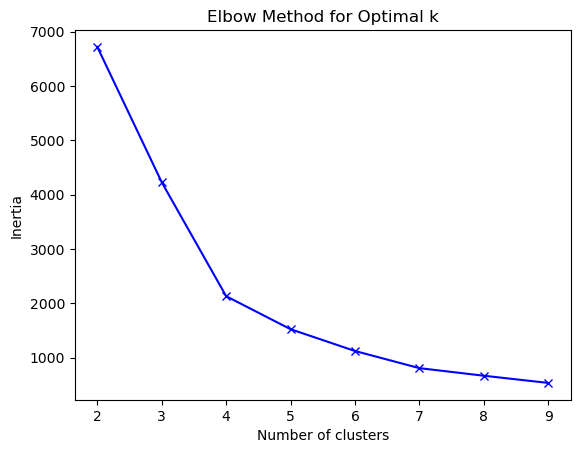

In [28]:
# find optimal n_clusters
elbow_method(start=2, end=10, stepsize=1, df=df_fixed_crime)

#### Based on elbow method, optimal n_clusters = 4

In [29]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(df_fixed_crime)

KMeans(n_clusters=4, n_init=10)

In [30]:
# define function to visualize geospatial data

def geospatial_visualization(latitude, longitude, cluster_labels):
    """
    latitude = pandas series or list of latitude
    longitude = pandas series or list of longitude
    cluster_labels = pandas series or list of cluster labels
    """
    
    # Center map around the mean latitude and longitude
    mean_latitude = latitude.mean()
    mean_longitude = longitude.mean()
    
    # Create a map centered around the mean coordinates
    mymap = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10, control_scale=True)
    
    # Define colors for six clusters
    cluster_colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink']
    
    # Add markers for each crime location with cluster color
    for lat, lon, cluster in zip(latitude, longitude, cluster_labels):
        folium.CircleMarker(
            [lat, lon],
            radius=4,
            color=cluster_colors[cluster],
            fill=True,
            fill_color=cluster_colors[cluster],
            fill_opacity=0.7,
            popup=f'Cluster {cluster}',
        ).add_to(mymap)
    
    # Display the map
    return mymap

In [31]:
# geospatial_visualization
geospatial_visualization(df_fixed_crime['latitude'], df_fixed_crime['longitude'], kmeans.labels_)

Note that there are a few outliers. We don't want to allocate resources to a broader region just because of these outliers. Let's explore other clustering methods to see if they provide better results.

#### 5.2 DBSCAN Clustering

##### k-distance graph
- The k-distance graph is primarily used to determine the optimal value of eps (epsilon) for the DBSCAN algorithm.
- For each data point, the distance to its k-th nearest neighbor is computed. For example, if k=2, the 2-distance of a point is the distance to its second nearest neighbor.
- These k-distances are then sorted in ascending order and plotted.
- A significant jump in distance between nearest points implies that the next point is relatively far away.

In [32]:
# define function to generate k-distance graph

def k_distance(df):
    """ df = Dataframe consisting of x & y coordinates """
    
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors_fit = neighbors.fit(df_fixed_crime)
    distances, indices = neighbors_fit.kneighbors(df_fixed_crime)
    distances_with_indices = list(enumerate(distances[:, 1]))
    distances_with_indices.sort(key = lambda x: x[1])
    
    plt.plot([x[1] for x in distances_with_indices])
    plt.title('k-Distance Graph')
    plt.xlabel('Points')
    plt.ylabel('Distance')
    plt.grid()
    plt.show()

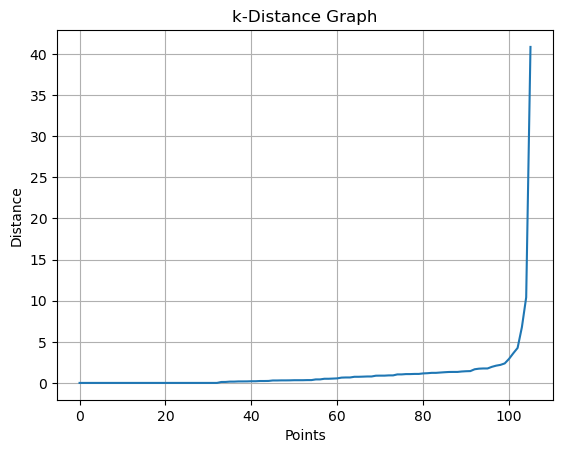

In [33]:
# generate k-distance graph
k_distance(df_fixed_crime)

Epsilon to be set as 5.

In [34]:
# initiate DBSCAN model
minPoints = 2
epsilon = 5
dbscan = DBSCAN(eps=epsilon, min_samples=minPoints)

# fit the model
dbscan.fit(df_fixed_crime)

# get the labels
dbscan_labels = dbscan.labels_

In [35]:
# geospatial_visualization
geospatial_visualization(df_fixed_crime['latitude'], df_fixed_crime['longitude'], dbscan_labels)

Outliers succesfully isolated but clusters' size is less uniform.

#### 5.3 Hierarchical Clustering (Agglomerative Clustering)

In [36]:
# Initiate Agglomerative Clustering model
n_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters = n_clusters)

# fit the model
agg_clustering.fit(df_fixed_crime)

# get the labels
agg_labels = agg_clustering.labels_

In [37]:
# geospatial_visualization
geospatial_visualization(df_fixed_crime['latitude'], df_fixed_crime['longitude'], agg_labels)

Uniform clusters' size but not able to isolate outliers.

#### 5.4 k-distance graph to remove outliers before applying KMeans clustering

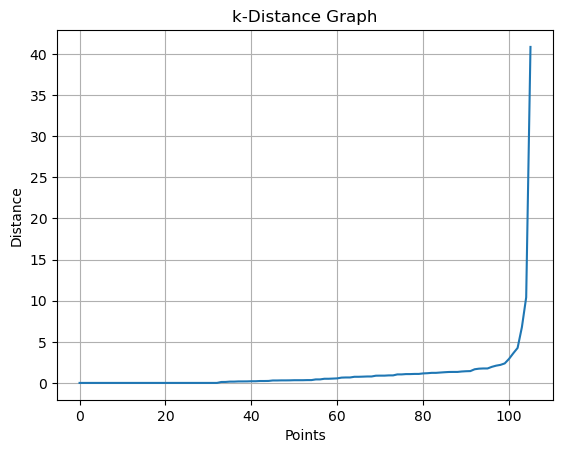

In [38]:
# generate k-distance graph
k_distance(df_fixed_crime)

There is a significant jump in distance at distance > 5. Therefore, we will define outliers as those with a distance greater than 5 from their nearest neighbor.

In [39]:
# define function to return outliers' dataframe indices

def remove_outliers(df, distance_threshold):
    """
    df = Dataframe consisting of x & y coordinates
    distance_threshold is derived from k-distance graph
    """

    # Compute k-distances (k=2)
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors_fit = neighbors.fit(df)
    distances, indices = neighbors_fit.kneighbors(df)

    # Sort distances and keep track of original indices
    distances_with_indices = list(enumerate(distances[:, 1]))
    distances_with_indices.sort(key = lambda x: x[1])

    # Identify indices of outliers
    outliers_indices = [x[0] for x in distances_with_indices if x[1] > distance_threshold]

    # remove outliers from df
    df_no_outliers = df.drop(df.index[outliers_indices])
    
    return df_no_outliers     # function returns a new dataframe with outliers removed

In [40]:
# generate another df with outliers removed
df_no_outliers = remove_outliers(df_fixed_crime, distance_threshold =5)

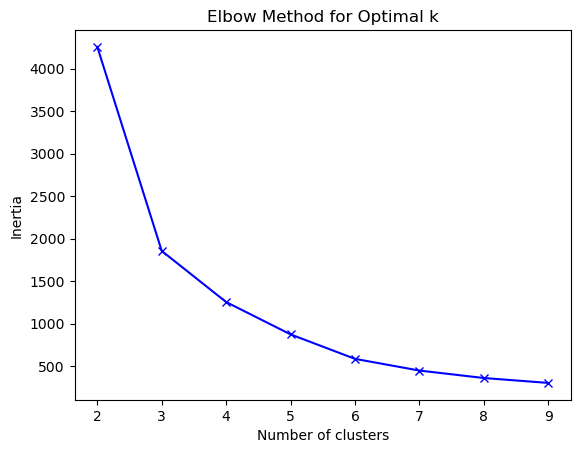

In [41]:
# use elbow_method function defined earlier to find optimal n_clusters for KMeans
elbow_method(start=2, end=10, stepsize=1, df=df_no_outliers)

Optimal n_clusters = 4

In [42]:
n_clusters_no_outliers = 4
kmeans_no_outliers = KMeans(n_clusters=n_clusters_no_outliers, n_init=10)
kmeans_no_outliers.fit(df_no_outliers)

KMeans(n_clusters=4, n_init=10)

In [43]:
geospatial_visualization(df_no_outliers['latitude'], df_no_outliers['longitude'], kmeans_no_outliers.labels_)

Of the four models evaluated:
- KMeans Clustering
- DBSCAN
- Hierarchical Clustering
- KMeans Clustering (with outliers removed)

KMeans Clustering (with outliers removed) produced the best results, demonstrating higher cluster density and more uniformly sized clusters.

- Cybercrime clusters mainly in LA, Memphis, Washington, Philadelphia and NY.
- These cities are targets probably due to their high population density, significant financial and tech industries, and greater internet connectivity, which can attract cybercriminals seeking lucrative opportunities.

#### 5.5 Validate best model on other crime types

In [44]:
# select crime type
crime_category_selection = 'drug'     # Change to analyze other crime_type

In [45]:
df_fixed_crime = df.loc[df['crime_type'].apply(lambda x: crime_category_selection in x), ['latitude', 'longitude']]

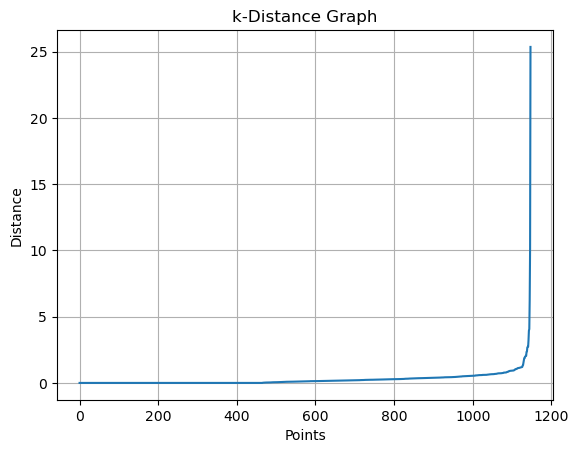

In [46]:
# generate k-distance graph
k_distance(df_fixed_crime)

There is a significant jump in distance at distance > 1. Therefore, we will define outliers as those with a distance greater than 1 from their nearest neighbor.

In [47]:
# generate another df with outliers removed
df_no_outliers = remove_outliers(df_fixed_crime, distance_threshold =1)

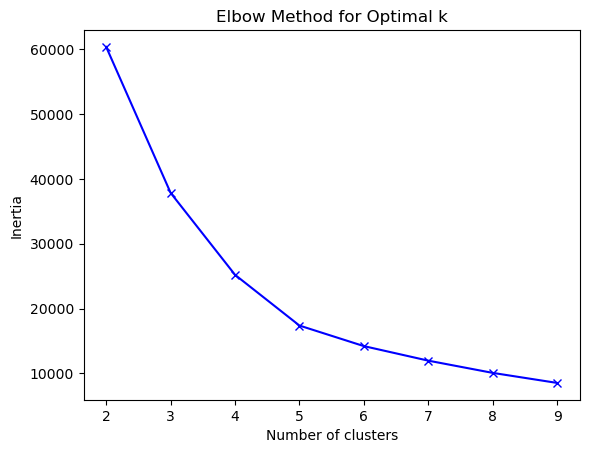

In [48]:
# use elbow_method function defined earlier to find optimal n_clusters for KMeans
elbow_method(start=2, end=10, stepsize=1, df=df_no_outliers)

Optimal n_clusters = 5

In [49]:
n_clusters_no_outliers = 5
kmeans_no_outliers = KMeans(n_clusters=n_clusters_no_outliers, n_init=10)
kmeans_no_outliers.fit(df_no_outliers)

KMeans(n_clusters=5, n_init=10)

In [50]:
geospatial_visualization(df_no_outliers['latitude'], df_no_outliers['longitude'], kmeans_no_outliers.labels_)

- The best model is validated on another crime type (drug offenses) with a different distribution of hotspots. 
- KMeans clustering (with prior outliers removal) again performs better, demonstrating higher cluster density and more uniformly sized clusters. 
- Clusters information allows law enforcement to allocate resources more effectively by targeting areas with higher crime rates, and optimizing patrols.

# 6. Crime rate by location & time

In [51]:
# select location
location_selection = 'washington'     # Change to analyze other locations

In [52]:
df_fixed_location = df.loc[df['location'].apply(lambda x: location_selection in x), ['year', 'crime_category']]

In [53]:
categories = ['property_and_financial_crimes', 'general_enforcement', 'violent_crimes', 'traffic_and_narcotics', 'sexual_and_exploitation_crimes']
categories_count = {}

for category in categories:
    category_count = df_fixed_location.groupby('year')['crime_category'].apply(lambda x: x.apply(lambda y: category in y).sum())
    categories_count[category] = category_count

categories_count_df = pd.DataFrame(categories_count)
categories_count_df

,property_and_financial_crimes,general_enforcement,violent_crimes,traffic_and_narcotics,sexual_and_exploitation_crimes
year,,,,,
2009,513,237,151,81,14
2010,582,223,180,92,24
2011,868,271,269,179,23
2012,520,193,142,92,29
2013,70,32,19,18,3
2014,60,26,32,18,2
2015,86,23,45,33,5
2016,67,28,31,21,7
2017,55,22,25,14,5


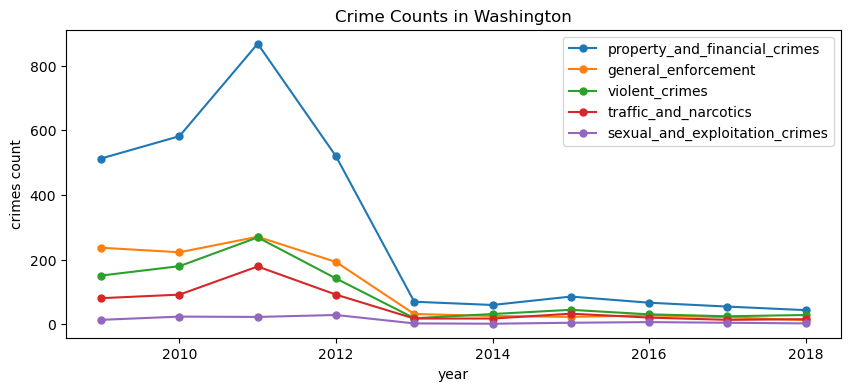

In [56]:
plt.figure(figsize = (10,4))
plt.plot(categories_count_df, marker='o', markersize=5, linestyle='-', label=categories)
plt.legend()
plt.xlabel('year')
plt.ylabel('crimes count')
plt.title(f'Crime Counts in {(location_selection).capitalize()}')
plt.show()

- Using NLP techniques to extract crime types also enables us to perform EDA, such as analyzing how crime rates change over time, which is crucial for identifying trends and developing informed crime prevention strategies.
-  Crime rates in Washington decreased, likely due to better law enforcement strategies. For example, in the early 2010s, many agencies in Washington adopted advanced methods like community policing and data-driven approaches such as CompStat. These strategies helped target crime hotspots more effectively. 
- Additionally, the economic recovery after the Great Recession likely contributed to the decline in crime rates, as higher employment and better economic stability often lead to fewer economic-related crimes.

# 7. Summary & Suggestion

- In summary, this project has developed and applied advanced methodologies for analyzing crime data, focusing on NLP and clustering techniques.
- It is recommended to refine clustering methodologies to incorporate both location and crime type, to identify specific crime patterns unique to different areas and types of crime.


In [55]:
print("Codes beyond this line will not be executed.")

# Stop the kernel after this line
raise SystemExit("Stopped kernel execution.")

Codes beyond this line will not be executed.


SystemExit: Stopped kernel execution.

C:\Users\S.Khoo\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Codes not used <big>⬇️</big>

### Text vectorization

TF-IDF = Term Frequency - Inverse Document Frequency

Text vectorization only for `crime_category`. `Latitude` and `longitude` are of continuous data type.

In [ ]:
# create a matrix of words count from the text
tfidf = TfidfVectorizer()

# do the actual counting 
crime_category_tfidf = tfidf.fit_transform(df['crime_category'])

### Truncated SVD (Singular Value Decomposition) for dimensionality reduction

#### Extra note: Brief comparison among different dimensionality reduction techniques
##### 1. Principal Component Analysis (PCA)
- PCA is generally used for reducing the dimensionality of continuous numerical data while preserving as much variance as possible.

##### 2. Singular Value Decomposition (SVD)
- SVD is a matrix factorization technique that decomposes a matrix into three other matrices (U, Σ, and V^T). In the context of text data, a variant called Truncated SVD (or Latent Semantic Analysis, LSA) is often used.

##### 3. Linear Discriminant Analysis (LDA)
- LDA is a technique used for both dimensionality reduction and classification. It finds a linear combination of features that best separate two or more classes.
- LDA is used in supervised learning contexts where you have labeled classes and want to reduce dimensions while maximizing class separability.
- PCA and SV are unsupervised methods

##### 4. SelectKBest
- SelectKBest is a feature selection method that selects the top k features based on a statistical test applied to each feature.
- It's used for feature selection rather than dimensionality reduction. It ranks all features and selects the top k most relevant features.

##### Which to Use for Text Vectorization?
- For text vectorization, the most commonly used technique for dimensionality reduction is Truncated SVD (LSA). Here's why:
- SVD can effectively reduce the dimensionality while capturing the latent semantic structure.
- Unsupervised nature: SVD does not require class labels, making it suitable for unsupervised contexts.

##### Code example for Singular Value Decomposition (SVD):

In [ ]:
# Find optimal n_components. By setting n_components = 2 for example, you are reducing your high-dimensional data to a 2-dimensional space.
# The goal is to retain as much of the original data's variance as possible with as few components as necessary.

n_components = []
explained_variances = []

threshold = 0.6
explained_variance = threshold    # Set an initial threshold value for while loop to run

while explained_variance >=threshold:
    
    for i in range(crime_category_tfidf.shape[1], 1, -1):
        
        svd = TruncatedSVD(n_components = i)
        lsa = make_pipeline(svd, Normalizer(copy=False))  # Normalization is often applied to ensure that the reduced-dimensionality vectors are unit vectors.
        crime_category_reduced = lsa.fit_transform(crime_category_tfidf)
        explained_variance = svd.explained_variance_ratio_.sum()
        n_components.append(i)
        explained_variances.append(explained_variance)
        
        if explained_variance < threshold:
            break

plt.plot(n_components, explained_variances)
plt.xlabel('n_components for SVD dimensionality reduction')
plt.ylabel('Sum of explained_variances')
plt.title('Find optimal n_components')

plt.show()

In [ ]:
n_components = 4     # optimal n_components derived above
svd = TruncatedSVD(n_components = n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))  # Normalization is often applied to ensure that the reduced-dimensionality vectors are unit vectors.
crime_category_reduced = lsa.fit_transform(crime_category_tfidf)

In [ ]:
crime_category_reduced     # ndarray. Need to be converted to dataframe before concatenating back with 'latitude' & 'longitude'

In [ ]:
# Define column names dynamically
columns = [f'component_{i+1}' for i in range(n_components)]

# Convert to DataFrame
crime_category_reduced_df = pd.DataFrame(crime_category_reduced, columns=columns)

In [ ]:
# Reset indices
crime_category_reduced_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# combine vectorized text (crime_category) with continuous features (latitude & longitude)
combined = pd.concat([df[['latitude', 'longitude']], crime_category_reduced_df], axis=1)

In [ ]:
# standardize the combined_dense_matrix
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined)